# Project Proposal Preliminary 2
## Peter Lee

### Objectives: Understand the needs of tele-healthcare
Throughout the world, the birthrate has been decreasing while the life expectancy has been increasing. With our sampled data of New York State population, we identified if this trend is true. Then, we look at the number of hospitals in each of the counties of New York and see how many of the population we assume to be in need the most actually has the accessibility.

In [6]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt


## Population Data using Census API 
### (Source: US Census)

In [15]:
key = '&key=45f7cf28147193e4f230d2aacbdf10faf4f06925'

#Assumtion: 60 and over more likely to be immobile
#Total!!Estimate!!Total population
#Total!!Estimate!!SELECTED AGE CATEGORIES!!60 years and over
#Total!!Estimate!!AGE!!Under 5 years 

pop = 'S0101_C01_001E'
pop60 = 'S0101_C01_028E'
pop5 = 'S0101_C01_002E'
disab = 'S1810_C01_001E'
disab65 = 'S1810_C01_017E'
disab75 = 'S1810_C01_018E'

ambul = 'S1810_C01_047E'
ambul65 = 'S1810_C01_052E'

variables = pop+','+pop60+','+pop5+','+disab+','+disab65+','+disab75

Pop_years = list(np.arange(2011,2019))
pop_data_coll = []
i = 0

for year in Pop_years:

#     print(i)
    url = 'https://api.census.gov/data/'+str(year)+'/acs/acs1/subject?get=NAME,'+variables+'&for=state:*'+key
    request = requests.get(url)
    pop_data_json = pd.read_json(request.content)
    pop_data = pop_data_json[1:]
    pop_data[[1,2,3,4,5,6]] = pop_data[[1,2,3,4,5,6]].astype('float64')
    if pop_data[2][1]<100:
        pop_data[2] = pop_data[2]*pop_data[1]/100
        pop_data[3] = pop_data[3]*pop_data[1]/100
    if pop_data[5][1]>0:    
        pop_data[6] = pop_data[5] + pop_data[6]
    pop_data[[1,2,3,4,5,6]] = pop_data[[1,2,3,4,5,6]].astype('int64')
    pop_data.index = pop_data[7].astype('int64')
    pop_data_coll.append(pop_data)
    i = i +1

c:\users\modul\venv\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\modul\venv\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\modul\venv\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/use

In [16]:
pop_assem = []
for county_n in pop_data_coll[0].index:
    
    pot_total = []
    pot_60 = []
    pot_5 = []
    disab_60 = []
    
    for y in range(len(pop_data_coll)):

        pot_total.append(pop_data_coll[y].loc[county_n][1])
        pot_60.append(pop_data_coll[y].loc[county_n][2])
        pot_5.append(pop_data_coll[y].loc[county_n][3])
        disab_60.append(pop_data_coll[y].loc[county_n][6])

    data = [list(Pop_years), pot_total, pot_60, pot_5, disab_60]
    df = pd.DataFrame(np.array(data).T, columns = ['Year', 'Pop', 'Pop_60', 'Pop_5', 'Disability_5'])
    pop_assem.append(df)

In [5]:
def fitting(pop_data): 
    
    # normalization
    span = np.max(pop_assem_disa)-np.min(pop_assem_disa)
    population = (pop_data-np.min(pop_data))/(span)

    # theta = [constant, slope]
    theta = np.array([1.,1., 1.]).reshape(3,1)

    #descending step
    alpha = .001
    #iteration
    epoch = 1000000
    #year with single digit
    x = np.arange(len(population)).reshape(1,-1)
    #ones for the constant 
    const = np.ones(len(population))
    #feature array
    features = np.append(const,x)
    features = np.append(features,x**2).reshape(3,-1).T
    #real value
    y = np.array(population).reshape(-1,1)
    #place to store the cost for debugging (in case if the step is too large)
    cost = np.zeros(epoch)
    m = len(Pop_years)

    #descending
    for i in range(epoch):

        y_est = np.dot(features,theta)
        e = (y_est-y)
        d_theta = 2/m*np.dot(features.T,e)
        theta= theta-alpha*d_theta/m
        cost[i] = np.dot(x,e**2)/m

    return span, e, y_est, theta 

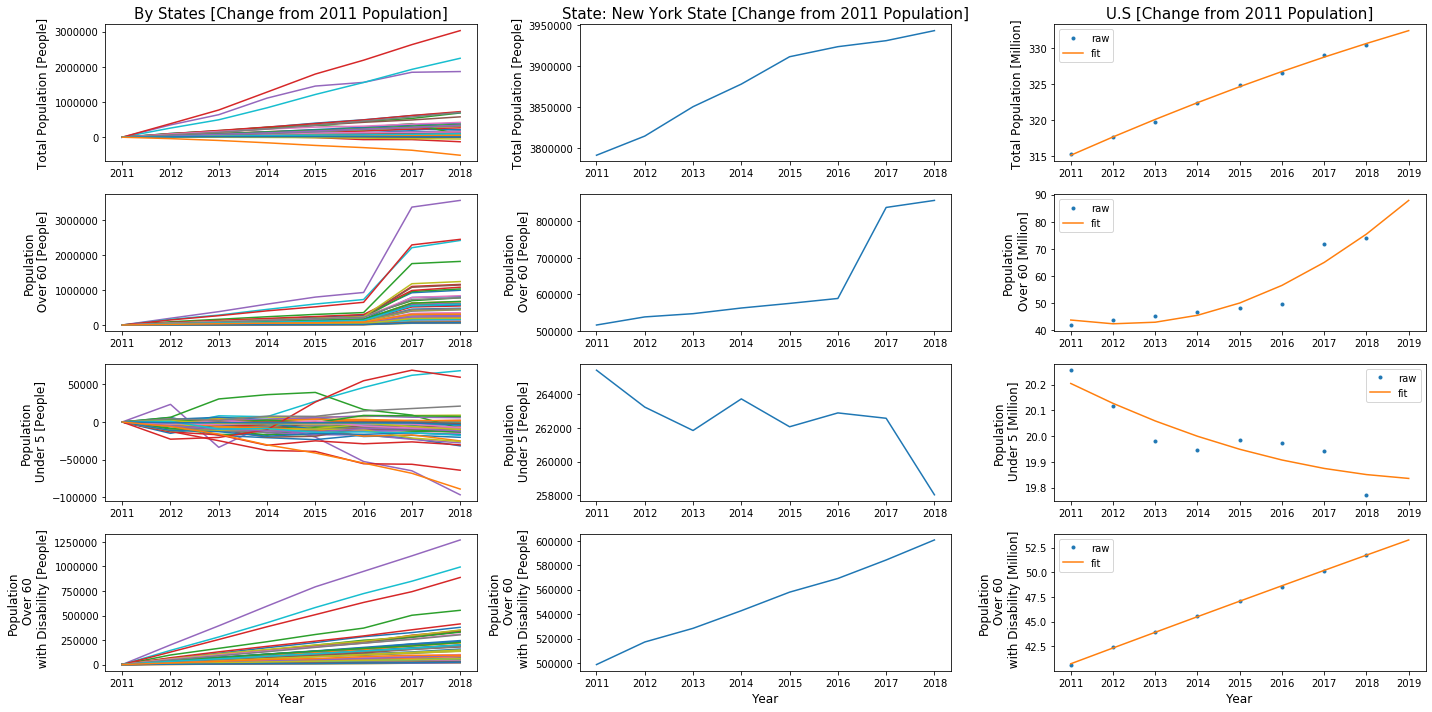

In [19]:
pop_assem_sum = np.zeros(8)
pop_assem_60 = np.zeros(8)
pop_assem_5 = np.zeros(8)
pop_assem_disa = np.zeros(8)
pop_set = []
pop60_set = []
pop5_set = []
popD60_set = []

fig, axs = plt.subplots(4,3, figsize = (20, 10))

for i in range(len(pop_assem)):
    ax = axs[0,0]
    ax.plot(pop_assem[i].Year,pop_assem[i].Pop-pop_assem[i].Pop[0])
    ax.set_ylabel('Total Population [People]', fontsize = 12)
    ax.set_title('By States [Change from 2011 Population]', fontsize = 15)
    
    ax = axs[1,0]
    ax.plot(pop_assem[i].Year,pop_assem[i].Pop_60-pop_assem[i].Pop_60[0])
    ax.set_ylabel('Population\n Over 60 [People]', fontsize = 12)    

    ax = axs[2,0]
    ax.plot(pop_assem[i].Year,pop_assem[i].Pop_5-pop_assem[i].Pop_5[0])
    ax.set_ylabel('Population\n Under 5 [People]', fontsize = 12)
    
    ax = axs[3,0]
    ax.plot(pop_assem[i].Year,pop_assem[i].Disability_5-pop_assem[i].Disability_5[0])
    ax.set_ylabel('Population\n Over 60\n  with Disability [People]', fontsize = 12)
    ax.set_xlabel('Year', fontsize = 12)
    
    pop_set.append(pop_assem[i].Pop)
    pop60_set.append(pop_assem[i].Pop_60)
    pop5_set.append(pop_assem[i].Pop_5)
    popD60_set.append(pop_assem[i].Disability_5)

    
    pop_assem_sum = pop_assem_sum+pop_assem[i].Pop
    pop_assem_60 = pop_assem_60+pop_assem[i].Pop_60
    pop_assem_5 = pop_assem_5+pop_assem[i].Pop_5
    pop_assem_disa = pop_assem_disa+pop_assem[i].Disability_5

    if i == len(pop_assem)-1:
        k = 36

        ax = axs[0,1]
        ax.plot(pop_assem[k].Year,pop_assem[k].Pop)
        ax.set_ylabel('Total Population [People]', fontsize = 12)
        ax.set_title('State: New York State [Change from 2011 Population]', fontsize = 15)

        ax = axs[1,1]
        ax.plot(pop_assem[k].Year,pop_assem[k].Pop_60)
        ax.set_ylabel('Population\n Over 60 [People]', fontsize = 12)    

        ax = axs[2,1]
        ax.plot(pop_assem[k].Year,pop_assem[k].Pop_5)
        ax.set_ylabel('Population\n Under 5 [People]', fontsize = 12)

        ax = axs[3,1]
        ax.plot(pop_assem[k].Year,pop_assem[k].Disability_5)
        ax.set_ylabel('Population\n Over 60\n  with Disability [People]', fontsize = 12)
        ax.set_xlabel('Year', fontsize = 12)
        
        # Input (Features) for the quadratic predictive model
        Pop_year_2019 = np.append(Pop_years,2019)
        x = np.arange(len(Pop_year_2019)).reshape(1,-1)
        const = np.ones(len(Pop_year_2019))        
        features = np.append(const,x)
        features = np.append(features,x**2).reshape(3,-1).T 
        

        ax = axs[0,2]
        ax.plot(pop_assem[i].Year,pop_assem_sum/1000000,'.')

        span, e, y_est, theta = fitting(pop_assem_sum)
        ax.plot(Pop_year_2019, (np.dot(features,theta)*span+min(pop_assem_sum))/1000000)

        ax.set_ylabel('Total Population [Million]', fontsize = 12)
        ax.set_title('U.S [Change from 2011 Population]', fontsize = 15)
        ax.legend(['raw','fit'])
   
        ax = axs[1,2]
        ax.plot(pop_assem[i].Year,pop_assem_60/1000000,'.')
 
        span, e, y_est, theta = fitting(pop_assem_60)
        ax.plot(Pop_year_2019, (np.dot(features,theta)*span+min(pop_assem_60))/1000000)
        
        ax.set_ylabel('Population\n Over 60 [Million]', fontsize = 12)    
        ax.legend(['raw','fit'])
        
        ax = axs[2,2]
        ax.plot(pop_assem[i].Year,pop_assem_5/1000000,'.')
         
        span, e, y_est, theta = fitting(pop_assem_5)
        ax.plot(Pop_year_2019, (np.dot(features,theta)*span+min(pop_assem_5))/1000000)

        ax.set_ylabel('Population\n Under 5 [Million]', fontsize = 12)
        ax.legend(['raw','fit'])
        
        ax = axs[3,2]
        ax.plot(pop_assem[i].Year,pop_assem_disa/1000000,'.')
        
        span, e, y_est, theta = fitting(pop_assem_disa)
        ax.plot(Pop_year_2019, (np.dot(features,theta)*span+min(pop_assem_disa))/1000000)

        ax.set_ylabel('Population\n Over 60\n  with Disability [Million]', fontsize = 12)
        ax.set_xlabel('Year', fontsize = 12)
        ax.legend(['raw','fit'])

        
    plt.tight_layout()


Text(0.5, 0, 'Year')

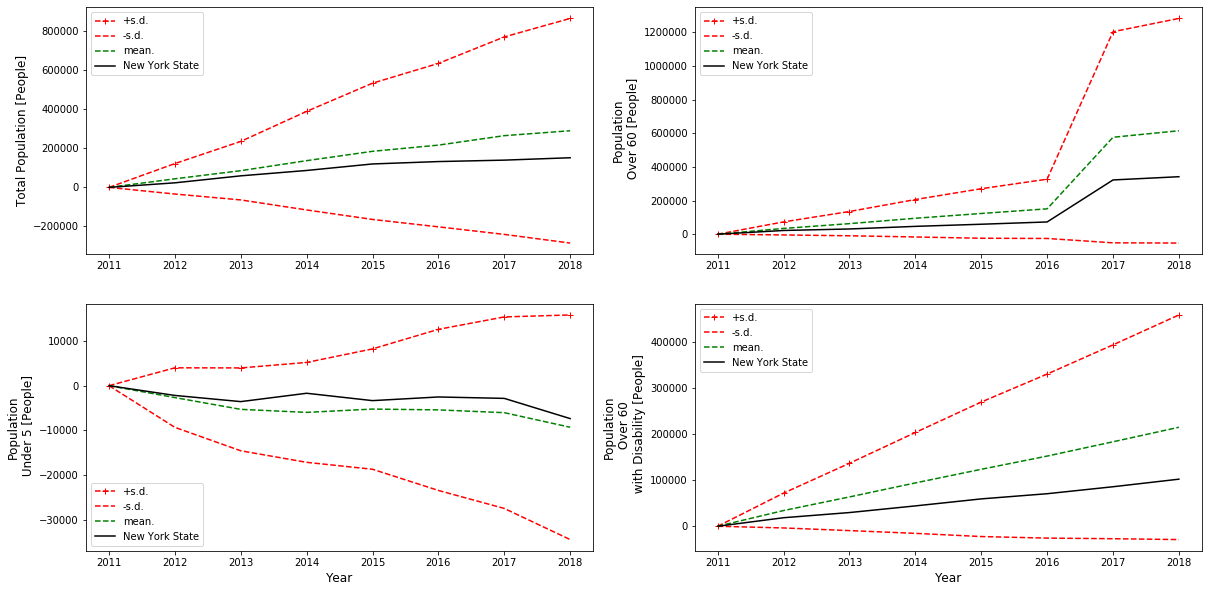

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [20]:
def find_stat(pop_data):
    
    pop_data = np.array(pop_data)-np.dot(np.array(pop_data)[:,0].reshape(-1,1), np.ones([1,8]))
    s_curve = np.std(np.array(pop_data), axis =0)
    u_curve = np.mean(np.array(pop_data), axis =0)
    
    return u_curve, s_curve

fig, axs = plt.subplots(2,2,figsize = (20, 10))

ax = axs[0,0]
u_curve, s_curve = find_stat(pop_set)
ax.plot(Pop_years, u_curve+s_curve ,'+r--')
ax.plot(Pop_years, u_curve-s_curve ,'r--')
ax.plot(Pop_years, u_curve ,'g--')
ax.plot(Pop_years, pop_assem[k].Pop-pop_assem[k].Pop[0] ,'k')
ax.legend(['+s.d.','-s.d.','mean.','New York State'])
ax.set_ylabel('Total Population [People]', fontsize = 12)

plt.figure ()
ax = axs[0,1]
u_curve, s_curve = find_stat(pop60_set)
ax.plot(Pop_years, u_curve+s_curve ,'+r--')
ax.plot(Pop_years, u_curve-s_curve ,'r--')
ax.plot(Pop_years, u_curve ,'g--')
ax.plot(Pop_years, pop_assem[k].Pop_60-pop_assem[k].Pop_60[0] ,'k')
ax.legend(['+s.d.','-s.d.','mean.','New York State'])
ax.set_ylabel('Population\n Over 60 [People]', fontsize = 12)    

plt.figure ()
ax = axs[1,0]
u_curve, s_curve = find_stat(pop5_set)
ax.plot(Pop_years, u_curve+s_curve ,'+r--')
ax.plot(Pop_years, u_curve-s_curve ,'r--')
ax.plot(Pop_years, u_curve ,'g--')
ax.plot(Pop_years, pop_assem[k].Pop_5-pop_assem[k].Pop_5[0] ,'k')
ax.legend(['+s.d.','-s.d.','mean.','New York State'])
ax.set_ylabel('Population\n Under 5 [People]', fontsize = 12)
ax.set_xlabel('Year', fontsize = 12)

plt.figure ()
ax = axs[1,1]
u_curve, s_curve = find_stat(popD60_set)
ax.plot(Pop_years, u_curve+s_curve ,'+r--')
ax.plot(Pop_years, u_curve-s_curve ,'r--')
ax.plot(Pop_years, u_curve ,'g--')
ax.plot(Pop_years, pop_assem[k].Disability_5-pop_assem[k].Disability_5[0] ,'k')
ax.legend(['+s.d.','-s.d.','mean.','New York State'])
ax.set_ylabel('Population\n Over 60\n  with Disability [People]', fontsize = 12)
ax.set_xlabel('Year', fontsize = 12)


In [2]:
key = '&key=45f7cf28147193e4f230d2aacbdf10faf4f06925'

#Assumtion: 60 and over more likely to be immobile
#Total!!Estimate!!Total population
#Total!!Estimate!!SELECTED AGE CATEGORIES!!60 years and over
#Total!!Estimate!!AGE!!Under 5 years 

pop = 'S0101_C01_001E'
pop60 = 'S0101_C01_028E'
pop5 = 'S0101_C01_002E'
disab = 'S1810_C01_001E'
disab65 = 'S1810_C01_017E'
disab75 = 'S1810_C01_018E'

ambul = 'S1810_C01_047E'
ambul65 = 'S1810_C01_052E'

variables = pop+','+pop60+','+pop5+','+disab+','+disab65+','+disab75

Pop_years = list(np.arange(2011,2019))
pop_data_coll = []
i = 0

for year in Pop_years:

#     print(i)
    url = 'https://api.census.gov/data/'+str(year)+'/acs/acs1/subject?get=NAME,'+variables+'&for=county:*&in=state:36'+key
    request = requests.get(url)
    pop_data_json = pd.read_json(request.content)
    pop_data = pop_data_json[1:]
    pop_data[[1,2,3,4,5,6]] = pop_data[[1,2,3,4,5,6]].astype('float64')
    if pop_data[2][1]<100:
        pop_data[2] = pop_data[2]*pop_data[1]/100
        pop_data[3] = pop_data[3]*pop_data[1]/100
    if pop_data[5][1]>0:    
        pop_data[6] = pop_data[5] + pop_data[6]
    pop_data[[1,2,3,4,5,6]] = pop_data[[1,2,3,4,5,6]].astype('int64')
    pop_data.index = pop_data[8].astype('int64')
    pop_data_coll.append(pop_data)
    i = i +1

c:\users\modul\venv\lib\site-packages\pandas\core\frame.py:3489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
c:\users\modul\venv\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\modul\venv\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.or

In [4]:
pop_assem = []
for county_n in pop_data_coll[0].index:
    
    pot_total = []
    pot_60 = []
    pot_5 = []
    disab_60 = []
    
    for y in range(len(pop_data_coll)):

        pot_total.append(pop_data_coll[y].loc[county_n][1])
        pot_60.append(pop_data_coll[y].loc[county_n][2])
        pot_5.append(pop_data_coll[y].loc[county_n][3])
        disab_60.append(pop_data_coll[y].loc[county_n][6])

    data = [list(Pop_years), pot_total, pot_60, pot_5, disab_60]
    df = pd.DataFrame(np.array(data).T, columns = ['Year', 'Pop', 'Pop_60', 'Pop_5', 'Disability_5'])
    pop_assem.append(df)

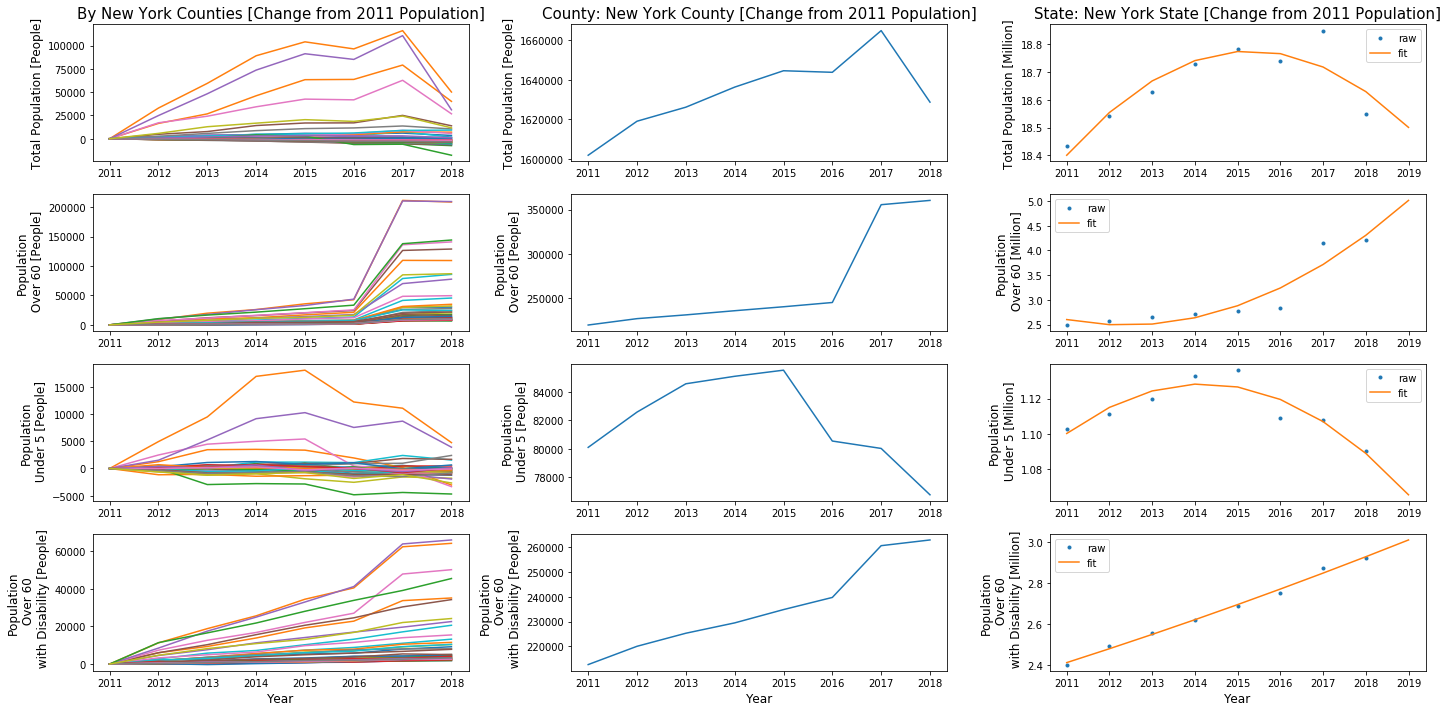

In [7]:
pop_assem_sum = np.zeros(8)
pop_assem_60 = np.zeros(8)
pop_assem_5 = np.zeros(8)
pop_assem_disa = np.zeros(8)
pop_set = []
pop60_set = []
pop5_set = []
popD60_set = []

fig, axs = plt.subplots(4,3, figsize = (20, 10))

for i in range(len(pop_assem)):
    ax = axs[0,0]
    ax.plot(pop_assem[i].Year,pop_assem[i].Pop-pop_assem[i].Pop[0])
    ax.set_ylabel('Total Population [People]', fontsize = 12)
    ax.set_title('By New York Counties [Change from 2011 Population]', fontsize = 15)
    
    ax = axs[1,0]
    ax.plot(pop_assem[i].Year,pop_assem[i].Pop_60-pop_assem[i].Pop_60[0])
    ax.set_ylabel('Population\n Over 60 [People]', fontsize = 12)    

    ax = axs[2,0]
    ax.plot(pop_assem[i].Year,pop_assem[i].Pop_5-pop_assem[i].Pop_5[0])
    ax.set_ylabel('Population\n Under 5 [People]', fontsize = 12)
    
    ax = axs[3,0]
    ax.plot(pop_assem[i].Year,pop_assem[i].Disability_5-pop_assem[i].Disability_5[0])
    ax.set_ylabel('Population\n Over 60\n  with Disability [People]', fontsize = 12)
    ax.set_xlabel('Year', fontsize = 12)
    
    pop_set.append(pop_assem[i].Pop)
    pop60_set.append(pop_assem[i].Pop_60)
    pop5_set.append(pop_assem[i].Pop_5)
    popD60_set.append(pop_assem[i].Disability_5)

    
    pop_assem_sum = pop_assem_sum+pop_assem[i].Pop
    pop_assem_60 = pop_assem_60+pop_assem[i].Pop_60
    pop_assem_5 = pop_assem_5+pop_assem[i].Pop_5
    pop_assem_disa = pop_assem_disa+pop_assem[i].Disability_5

    if i == len(pop_assem)-1:
        k = 16

        ax = axs[0,1]
        ax.plot(pop_assem[k].Year,pop_assem[k].Pop)
        ax.set_ylabel('Total Population [People]', fontsize = 12)
        ax.set_title('County: New York County [Change from 2011 Population]', fontsize = 15)

        ax = axs[1,1]
        ax.plot(pop_assem[k].Year,pop_assem[k].Pop_60)
        ax.set_ylabel('Population\n Over 60 [People]', fontsize = 12)    

        ax = axs[2,1]
        ax.plot(pop_assem[k].Year,pop_assem[k].Pop_5)
        ax.set_ylabel('Population\n Under 5 [People]', fontsize = 12)

        ax = axs[3,1]
        ax.plot(pop_assem[k].Year,pop_assem[k].Disability_5)
        ax.set_ylabel('Population\n Over 60\n  with Disability [People]', fontsize = 12)
        ax.set_xlabel('Year', fontsize = 12)
        
        # Input (Features) for the quadratic predictive model
        Pop_year_2019 = np.append(Pop_years,2019)
        x = np.arange(len(Pop_year_2019)).reshape(1,-1)
        const = np.ones(len(Pop_year_2019))        
        features = np.append(const,x)
        features = np.append(features,x**2).reshape(3,-1).T 
        

        ax = axs[0,2]
        ax.plot(pop_assem[i].Year,pop_assem_sum/1000000,'.')

        span, e, y_est, theta = fitting(pop_assem_sum)
        ax.plot(Pop_year_2019, (np.dot(features,theta)*span+min(pop_assem_sum))/1000000)

        ax.set_ylabel('Total Population [Million]', fontsize = 12)
        ax.set_title('State: New York State [Change from 2011 Population]', fontsize = 15)
        ax.legend(['raw','fit'])
   
        ax = axs[1,2]
        ax.plot(pop_assem[i].Year,pop_assem_60/1000000,'.')
 
        span, e, y_est, theta = fitting(pop_assem_60)
        ax.plot(Pop_year_2019, (np.dot(features,theta)*span+min(pop_assem_60))/1000000)
        
        ax.set_ylabel('Population\n Over 60 [Million]', fontsize = 12)    
        ax.legend(['raw','fit'])
        
        ax = axs[2,2]
        ax.plot(pop_assem[i].Year,pop_assem_5/1000000,'.')
         
        span, e, y_est, theta = fitting(pop_assem_5)
        ax.plot(Pop_year_2019, (np.dot(features,theta)*span+min(pop_assem_5))/1000000)

        ax.set_ylabel('Population\n Under 5 [Million]', fontsize = 12)
        ax.legend(['raw','fit'])
        
        ax = axs[3,2]
        ax.plot(pop_assem[i].Year,pop_assem_disa/1000000,'.')
        
        span, e, y_est, theta = fitting(pop_assem_disa)
        ax.plot(Pop_year_2019, (np.dot(features,theta)*span+min(pop_assem_disa))/1000000)

        ax.set_ylabel('Population\n Over 60\n  with Disability [Million]', fontsize = 12)
        ax.set_xlabel('Year', fontsize = 12)
        ax.legend(['raw','fit'])

        
    plt.tight_layout()


Text(0.5, 0, 'Year')

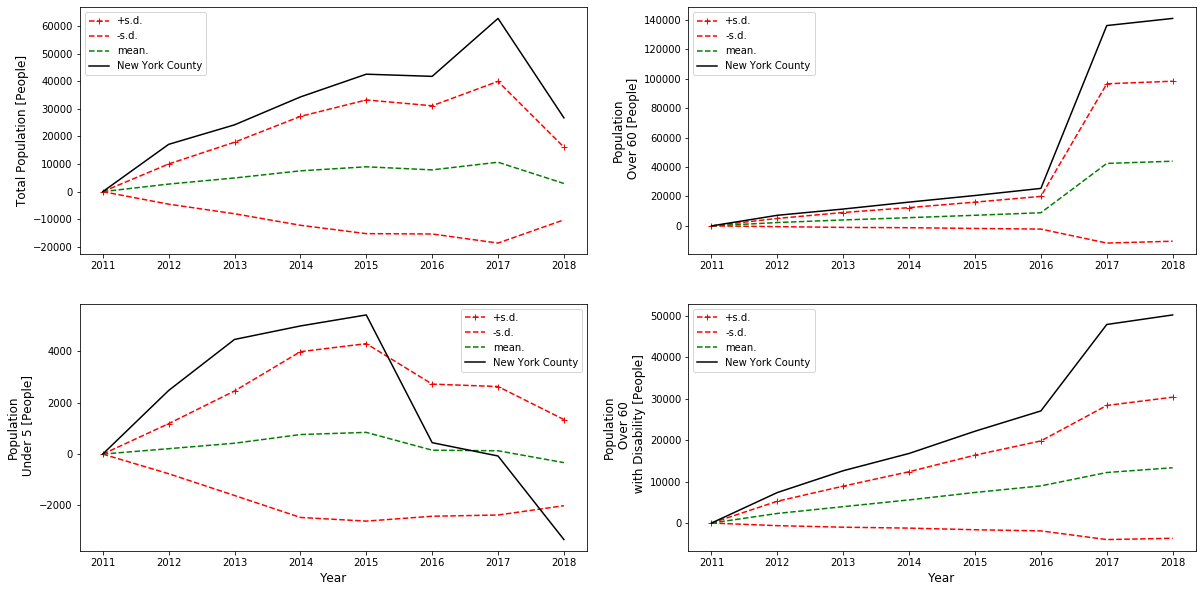

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [8]:
def find_stat(pop_data):
    
    pop_data = np.array(pop_data)-np.dot(np.array(pop_data)[:,0].reshape(-1,1), np.ones([1,8]))
    s_curve = np.std(np.array(pop_data), axis =0)
    u_curve = np.mean(np.array(pop_data), axis =0)
    
    return u_curve, s_curve

fig, axs = plt.subplots(2,2,figsize = (20, 10))

ax = axs[0,0]
u_curve, s_curve = find_stat(pop_set)
ax.plot(Pop_years, u_curve+s_curve ,'+r--')
ax.plot(Pop_years, u_curve-s_curve ,'r--')
ax.plot(Pop_years, u_curve ,'g--')
ax.plot(Pop_years, pop_assem[k].Pop-pop_assem[k].Pop[0] ,'k')
ax.legend(['+s.d.','-s.d.','mean.','New York County'])
ax.set_ylabel('Total Population [People]', fontsize = 12)

plt.figure ()
ax = axs[0,1]
u_curve, s_curve = find_stat(pop60_set)
ax.plot(Pop_years, u_curve+s_curve ,'+r--')
ax.plot(Pop_years, u_curve-s_curve ,'r--')
ax.plot(Pop_years, u_curve ,'g--')
ax.plot(Pop_years, pop_assem[k].Pop_60-pop_assem[k].Pop_60[0] ,'k')
ax.legend(['+s.d.','-s.d.','mean.','New York County'])
ax.set_ylabel('Population\n Over 60 [People]', fontsize = 12)    

plt.figure ()
ax = axs[1,0]
u_curve, s_curve = find_stat(pop5_set)
ax.plot(Pop_years, u_curve+s_curve ,'+r--')
ax.plot(Pop_years, u_curve-s_curve ,'r--')
ax.plot(Pop_years, u_curve ,'g--')
ax.plot(Pop_years, pop_assem[k].Pop_5-pop_assem[k].Pop_5[0] ,'k')
ax.legend(['+s.d.','-s.d.','mean.','New York County'])
ax.set_ylabel('Population\n Under 5 [People]', fontsize = 12)
ax.set_xlabel('Year', fontsize = 12)

plt.figure ()
ax = axs[1,1]
u_curve, s_curve = find_stat(popD60_set)
ax.plot(Pop_years, u_curve+s_curve ,'+r--')
ax.plot(Pop_years, u_curve-s_curve ,'r--')
ax.plot(Pop_years, u_curve ,'g--')
ax.plot(Pop_years, pop_assem[k].Disability_5-pop_assem[k].Disability_5[0] ,'k')
ax.legend(['+s.d.','-s.d.','mean.','New York County'])
ax.set_ylabel('Population\n Over 60\n  with Disability [People]', fontsize = 12)
ax.set_xlabel('Year', fontsize = 12)


## Hospital Data from HTML 
### (Source: Homeland Infrastructure Foundation-Level Data)

In [11]:
url_hospital = 'https://services1.arcgis.com/Hp6G80Pky0om7QvQ/arcgis/rest/services/Hospitals_1/FeatureServer/0/query?outFields=*&where=1%3D1&outFields=NAME,ADDRESS,STATE,ZIP,ZIP4,TYPE,STATUS,POPULATION,COUNTY,SOURCE,STATE_ID,CITY&outSR=4326&f=json'
hospital = requests.get(url_hospital)

x = json.dumps(hospital.json())
y = json.loads(x)

NAME = []
STATE = []
COUNTY = []

for features in y['features']:
    if features['attributes']['STATE'] == 'NY':
        NAME.append(features['attributes']['NAME'])
        STATE.append(features['attributes']['STATE'])
        COUNTY.append(features['attributes']['COUNTY'])

county_df = pd.Series(COUNTY)
county_df = county_df.value_counts()

n_hospital = pd.DataFrame(county_df)
n_hospital['county'] = n_hospital.index
n_hospital.county = n_hospital.county.str.replace(' ','')

In [12]:
data_2018 = pop_data_coll[7]
data_2018[0] = data_2018[0].str.upper().str.replace(' COUNTY, NEW YORK','').str.replace(' ','')
hospital_population = data_2018.set_index(0).join(n_hospital.set_index('county'))[[1,2,3,6,0]]
hospital_population = hospital_population.rename(columns={1: "Population[Total]", 2: "Population[60_Over]", 3: "Population[5_Under]", 6: "Population[60_Over_w_Disability]",  0: "Hospital_Counts"})
hospital_population['Density'] = hospital_population['Population[60_Over]']/hospital_population.Hospital_Counts
print('The minimum number of demands for the local hospital:'+ str(np.mean(hospital_population['Population[60_Over_w_Disability]']) ))
print('The density of elderly population per local hospital:'+ str(np.mean(hospital_population.Density) ))


#       ' is %f, but currently local hospital has capacity of %f'np.mean(hospital_population['Population[60_Over_w_Disability]']),np.mean(hospital_population.Density))

The minimum number of demands for the local hospital:74919.51282051283
The density of elderly population per local hospital:47191.77680952381


c:\users\modul\venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
